In [133]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sea
# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon
import fsps
from spec_id import Scale_model

import dynesty

In [134]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 20})

In [3]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1,
                           dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.25378,
               g102_lims=[7900, 11500], g141_lims=[11100, 16500],
            phot_errterm = 0.03, decontam = True)  

# Gs.Make_sim(0.019, 3.2, 0.2 , 1.2, 0)

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [14]:
template_path = '../templates/'
    
tau_range = np.load(template_path + 'tau_range.npy')
metal_range = np.load(template_path + 'metal_range.npy')
age_range = np.load(template_path + 'age_range.npy')
lwagrid = np.load(template_path + 'lwa_grid.npy')

ilwagrid = RegularGridInterpolator([metal_range,tau_range],lwagrid)

In [ ]:
[0.38550031, 1.66414577, 0.01919242, 0.0259676 ]

In [94]:
lwvs = ilwagrid([0.3855,.01])[0]

interp1d(lwvs,age_range)(1.664)


array(1.68747727)

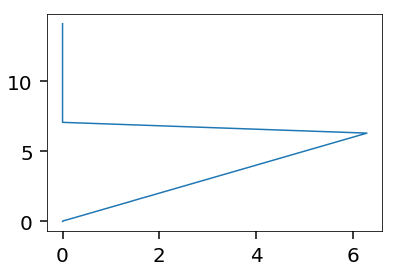

In [95]:
plt.plot(lwvs,age_range)

([<matplotlib.axis.XTick at 0x1a6e8742e8>,
 <a list of 6 Text xticklabel objects>)

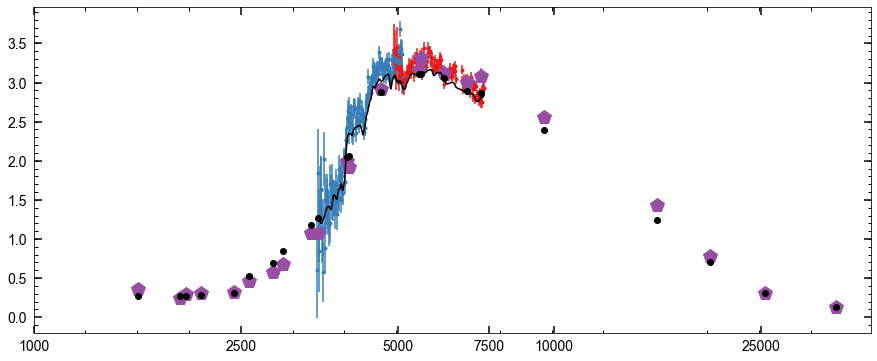

In [6]:
sp.params['logzsol'] = np.log10( 0.328 )
sp.params['tau'] = 0.01
sp.params['dust2'] = 0.2

wave, flux = sp.get_spectrum(tage = 3.21, peraa = True)
sp.params['tau'] = 0.01

wave, flux_b = sp.get_spectrum(tage = 0.01, peraa = True)

# 3.28629085e-01, 3.21741605e+00, 1.09566430e-02, 1.25318107e+00,
#        2.07411413e-01, 3.49182299e-05

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux + 0.000035 * flux_b, 1.2532)

PC= Full_scale(Gs, Pmfl)

Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k', zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])


In [8]:
(Bchi + Pchi + Rchi)//2

203.0

AttributeError: 'Gen_spec' object has no attribute 'Bmfl'

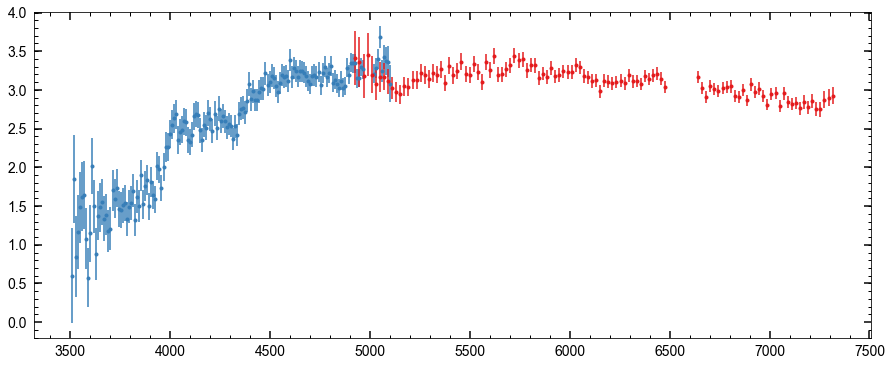

In [13]:
plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv_rf,Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Gs.Rwv_rf,Gs.Rfl*1E18,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(Gs.Bwv_rf, Gs.Bmfl*1E18, 'k', zorder=5)
plt.plot(Gs.Rwv_rf, Gs.Rmfl*1E18, 'k', zorder=5)


In [17]:
# prior transform
specz = 1.25378
bft = 0.545
bfd = 0.2

if bft <= 0.5:
    tau_limit = 0.5
    
if 0.5 < bft <= 1.0:
    tau_limit = 1.0
    
if bft > 1.0:
    tau_limit = 2.0
    
if bfd <= 0.5:
    dust_limit = 0.5
    
if 0.5 < bfd <= 1.0:
    dust_limit = 1.0
    
if bfd > 1.0:
    dust_limit = 2.0

def prior_transform(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = 5. * u[1] + 0.1
    t = tau_limit*u[2] + 0.01
    z = specz + 0.003 * (2*u[3] - 1)
    d = dust_limit*u[4]
    return [m, a, t, z, d]


In [5]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)


def Full_forward_model(spec, wave, flux, specz):
    Bmfl = forward_model_all_beams(spec.Bbeam, spec.Btrans, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = forward_model_all_beams(spec.Rbeam, spec.Rtrans, spec.Rwv, wave * (1 + specz), flux)
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Pmfl):
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    return PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):

    Bscale = Scale_model(spec.Bfl, spec.Ber, Bmfl)
    Rscale = Scale_model(spec.Rfl, spec.Rer, Rmfl)

    Bchi = np.sum(((((spec.Bfl/ Bscale) - Bmfl) / (spec.Ber / Bscale))**2))
    Rchi = np.sum(((((spec.Rfl/ Rscale) - Rmfl) / (spec.Rer / Rscale))**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Bchi, Rchi, Pchi

def loglikelihood(X):
#     m,a,t,z,d,bcomp = X
    m,a,t,z,d = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['tau'] = t
    sp.params['dust2'] = d
       
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
#     sp.params['tau'] = 0.01
#     wave_b, flux_b = sp.get_spectrum(tage = 0.01, peraa = True)
        
#     Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux + bcomp * flux_b, z)
    Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
    
    PC= Full_scale(Gs, Pmfl)

    Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)
                  
    return -0.5 * (Bchi + Rchi + Pchi)

In [19]:
import ipyparallel as ipp

rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

dview = rc[:]
dview.use_dill();

class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)

[0, 1, 2, 3]


In [20]:
%%px

# import environment
import fsps
from spec_exam import Gen_spec
from sim_engine import *
import dynesty
from scipy.interpolate import interp1d, RegularGridInterpolator

specz = 1.25378
bft = 0.545
bfd = 0.2

if bft <= 0.5:
    tau_limit = 0.5
    
if 0.5 < bft <= 1.0:
    tau_limit = 1.0
    
if bft > 1.0:
    tau_limit = 2.0
    
if bfd <= 0.5:
    dust_limit = 0.5
    
if 0.5 < bfd <= 1.0:
    dust_limit = 1.0
    
if bfd > 1.0:
    dust_limit = 2.0
    
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau = 0.1,
                           dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.25378, g102_lims=[7900, 11500], g141_lims=[11100, 16500],
                phot_errterm = 0.03, decontam = True)  

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)


def Full_forward_model(spec, wave, flux, specz):
    Bmfl = forward_model_all_beams(spec.Bbeam, spec.Btrans, spec.Bwv, wave * (1 + specz), flux)
    Rmfl = forward_model_all_beams(spec.Rbeam, spec.Rtrans, spec.Rwv, wave * (1 + specz), flux)
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Pmfl):
    PC = Scale_model(spec.Pflx, spec.Perr, Pmfl)
    return PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):

    Bscale = Scale_model(spec.Bfl, spec.Ber, Bmfl)
    Rscale = Scale_model(spec.Rfl, spec.Rer, Rmfl)

    Bchi = np.sum(((((spec.Bfl/ Bscale) - Bmfl) / (spec.Ber / Bscale))**2))
    Rchi = np.sum(((((spec.Rfl/ Rscale) - Rmfl) / (spec.Rer / Rscale))**2))
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Bchi, Rchi, Pchi

# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:',os.getpid())

[stdout:0] 
cleaned
Random seed: 57141
[stdout:1] 
cleaned
Random seed: 57146
[stdout:2] 
cleaned
Random seed: 57147
[stdout:3] 
cleaned
Random seed: 57148


[stderr:0] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
[stderr:1] 
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data[

In [24]:
# initialize our nested sampler
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim = 5, sample = 'rwalk',pool=pool, bound = 'single') 

In [25]:
# sample dynamically from the target distribution
dsampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)


iter: 19676 | batch: 8 | bound: 853 | nc: 25 | ncall: 454241 | eff(%):  4.332 | loglstar: -99.678 < -92.691 < -93.512 | logz: -101.898 +/-  0.107 | stop:  0.937            


In [26]:
# save results
dres = dsampler.results

# dresP = dsamplerP.results
# dresB = dsamplerB.results
# dresR = dsamplerR.results


In [39]:
'done'

'done'

In [45]:
from dynesty import plotting as dyplot

(<Figure size 1152x1152 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a7e2d8f60>,
       dtype=object))

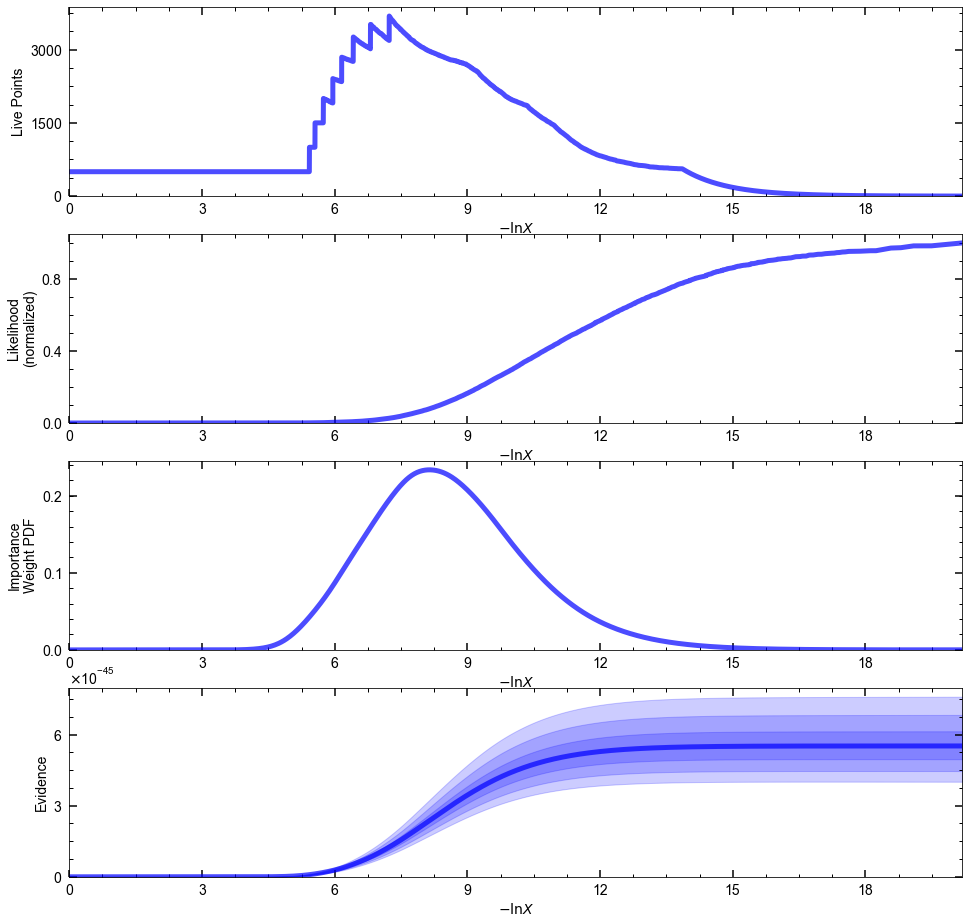

In [27]:
dyplot.runplot(dres)
# dyplot.runplot(dresB)
# dyplot.runplot(dresR)

# fig.tight_layout()

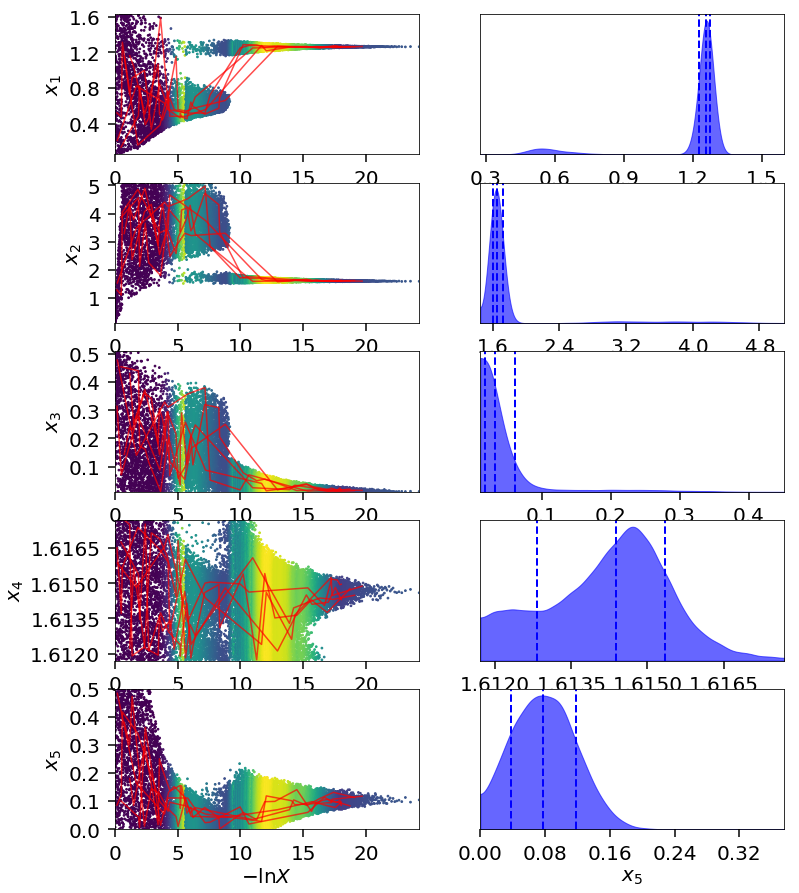

In [140]:
fig, axes = dyplot.traceplot(dres1b, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

(<Figure size 849.6x849.6 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a80068b70>,
       dtype=object))

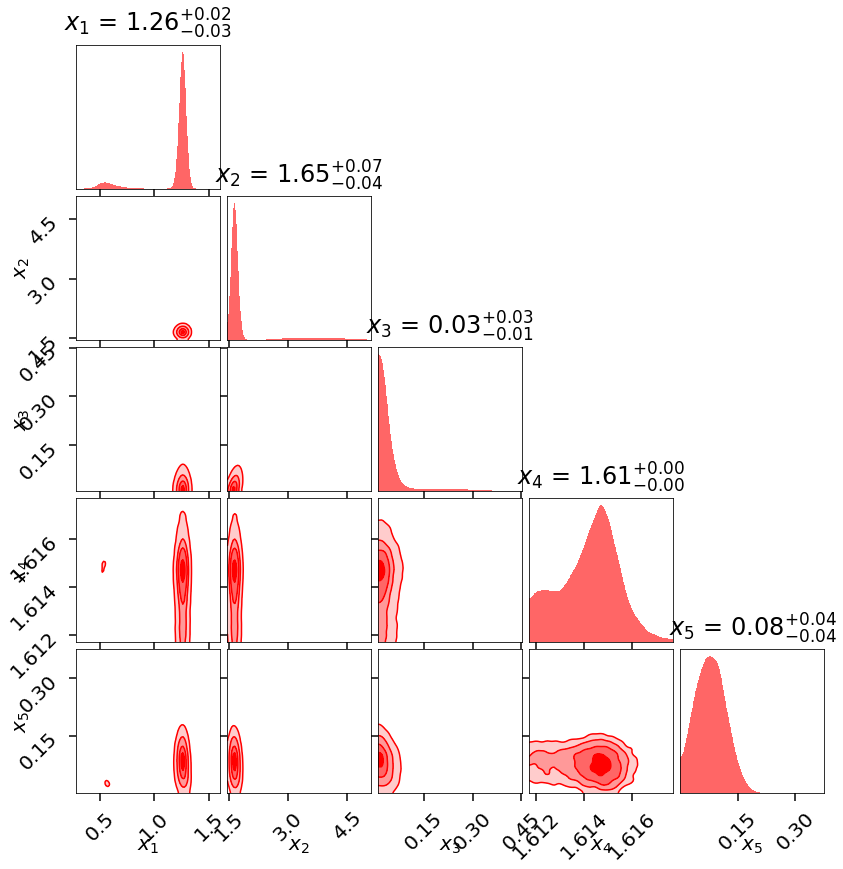

In [141]:
dyplot.cornerplot(dres1b, color='red', truths=None, truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, )

# dyplot.cornerplot(dres2, color='blue', truths=None, truth_color='black',
#                            show_titles=True, title_kwargs={'y': 1.05},
#                            quantiles=None, max_n_ticks=3, )

In [76]:
np.where(dres1.logl == max(dres1.logl)), max(dres1.logl), dres1b.samples[19675]

((array([19675]),),
 -92.67453214455456,
 array([0.32162171, 4.8060834 , 0.50480279, 1.25348012, 0.20300058]))

In [75]:
np.where(dres2.logl == max(dres2.logl)),max(dres2.logl), dres2b.samples[20070]

((array([20070]),),
 -92.61317041879032,
 array([3.29238735e-01, 4.40411106e+00, 4.08084650e-01, 1.25314634e+00,
        2.00337282e-01, 2.03617492e-05]))

In [65]:
sp.params['compute_light_ages'] = False

([<matplotlib.axis.XTick at 0x1a7f9b2470>,
 <a list of 6 Text xticklabel objects>)

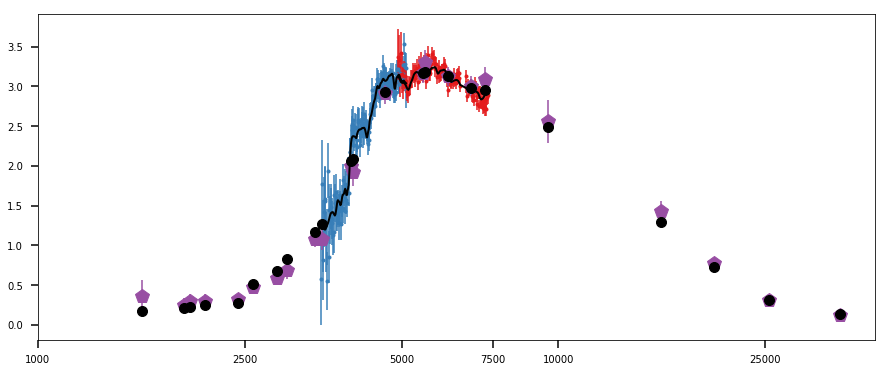

In [106]:
0.32460907,4.77548244,0.48342044,1.25301778,0.2076381

sp.params['logzsol'] = np.log10(0.3246 )
sp.params['tau'] = 0.483
sp.params['dust2'] = 0.207

wave, flux = sp.get_spectrum(tage = 4.775, peraa = True)

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, 1.253)
PC= Full_scale(Gs, Pmfl)
Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC * Bmfl)
Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC * Rmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18 / Bscale,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 / Rscale,Gs.Rer*1E18 / Rscale,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])


([<matplotlib.axis.XTick at 0x1a802334e0>,
 <a list of 6 Text xticklabel objects>)

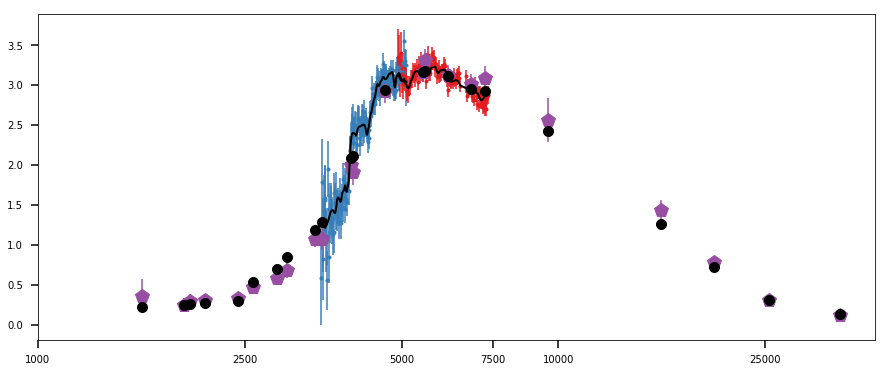

In [107]:
sp.params['logzsol'] = np.log10( 0.322 )
sp.params['tau'] = 0.3
sp.params['dust2'] = 0.2

wave, flux = sp.get_spectrum(tage =3.87, peraa = True)
sp.params['tau'] = 0.01
wave, flux_b = sp.get_spectrum(tage = 0.01, peraa = True)

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux + 0.00003 * flux_b, 1.2531)

PC= Full_scale(Gs, Pmfl)

Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC * Bmfl)
Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC * Rmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18 / Bscale,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 / Rscale,Gs.Rer*1E18 / Rscale,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])


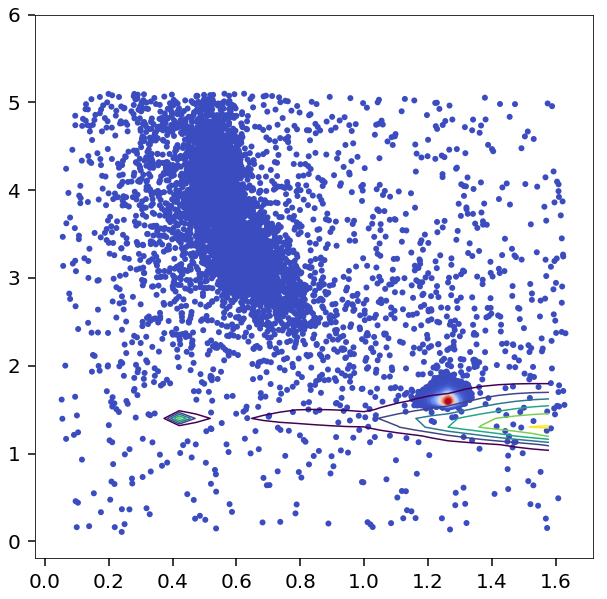

In [144]:
P = np.load('../../Quiescent_analysis/chidat/s41520_dtau_tZ_pos_lwa_3.npy')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
M,A=np.meshgrid(metal/0.019,age)

plt.figure(figsize=(10, 10))
plt.scatter(dres1b.samples[:, 0], dres1b.samples[:, 1],
               marker='o', c=np.exp(dres1b.logl), linewidths=(0.,), cmap='coolwarm')

# plt.scatter(dres.samples[:, 0][IDX[242]], dres.samples[:, 1][IDX[242]],
#                marker='o', c='k')
plt.contour(M,A,P)


In [145]:
from spec_tools import Oldest_galaxy
Oldest_galaxy(1.61)

4.021168565963132

In [10]:
import seaborn as sea

In [16]:
np.save('../data/out_dict/21156_onesed.npy', dres) 
# np.save('../data/out_dict/21156_g102.npy', dresB) 
# np.save('../data/out_dict/21156_g141.npy', dresR) 


In [135]:
dres1b = np.load('../data/posteriors/GSD_41520_nestedfit.npy').item()
# dres2b = np.load('../data/out_dict/21156_twosed.npy').item()
# dresG = np.load('../data/out_dict/21156_grism.npy').item()

In [39]:
sp.params['compute_light_ages'] = True
lwa1 = np.zeros(len(dres1.samples))
for i in range(len(dres1.samples)):
    sp.params['logzsol'] = np.log10(dres1.samples[i][0])
    sp.params['tau'] = dres1.samples[i][2]
    sp.params['dust2'] = dres1.samples[i][4]  
    wave, flux = sp.get_spectrum(tage = dres1.samples[i][1])
    
    lwa1[i] = interp1d(wave,flux)(4770)


In [40]:
sp.params['compute_light_ages'] = True
lwa2 = np.zeros(len(dres2.samples))
for i in range(len(dres2.samples)):
    sp.params['logzsol'] = np.log10(dres2.samples[i][0])
    sp.params['tau'] = dres2.samples[i][2]
    sp.params['dust2'] = dres2.samples[i][4]  
    wave, flux = sp.get_spectrum(tage = dres2.samples[i][1])
    
    lwa2[i] = interp1d(wave,flux)(4770)

In [38]:
sp.params['logzsol'] = np.log10(1)
sp.params['tau'] = 1
sp.params['dust2'] = 0.1  
wave, flux = sp.get_spectrum(tage = 0.5)
print(interp1d(wave,flux)(4770))

0.0920121117084283


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


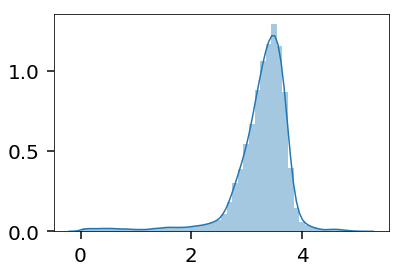

In [139]:
sea.distplot(dres1.samples[:,1])
# sea.distplot(lwa1)
# plt.xlim(0,5)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


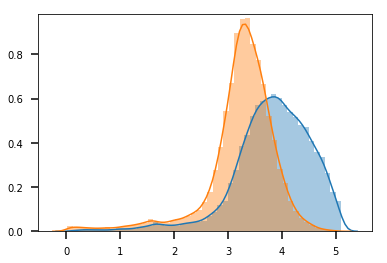

In [42]:
sea.distplot(dres2.samples[:,1])
sea.distplot(lwa2)

In [43]:
dres1.samples[:,1] = lwa1
dres2.samples[:,1] = lwa2

In [77]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0

[2.92597421e-05]


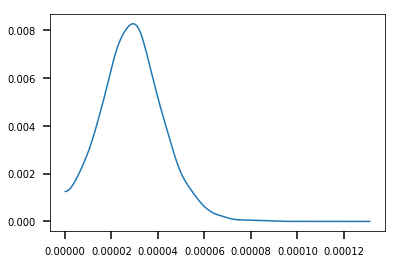

In [99]:
x,PX = Get_posterior(dres2b.samples[:,5], dres2['logwt'], dres2['logz'])

plt.plot(x,PX)
print(x[PX == max(PX)])

In [89]:
0.32460907,4.77548244,0.48342044,1.25301778,0.2076381

(0.32460907, 4.77548244, 0.48342044, 1.25301778)

In [100]:
0.32204752,3.8745717,0.30031549,1.25307038,0.20149674,2.92597421e-05

(0.32204752, 3.8745717, 0.30031549, 1.25307038, 0.20149674, 2.92597421e-05)

In [90]:
sp.params['dust_type'] = 2

(3.0, 4.698970004336019)

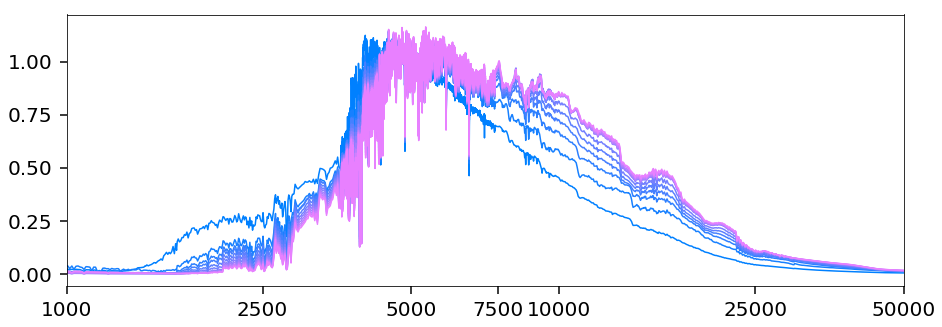

In [117]:
sp.params['dust2'] = 0

plt.figure(figsize=[15,5])
for i in range(len(metal_range)):
    sp.params['logzsol'] = np.log10(metal_range[i])
    wave,flux = sp.get_spectrum(tage=2.5,peraa=True)
    plt.plot(np.log10(wave),flux / flux[2000] , color = [i / len(metal_range),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))


In [119]:
AGE = np.arange(1,6,.1)

(3.0, 4.698970004336019)

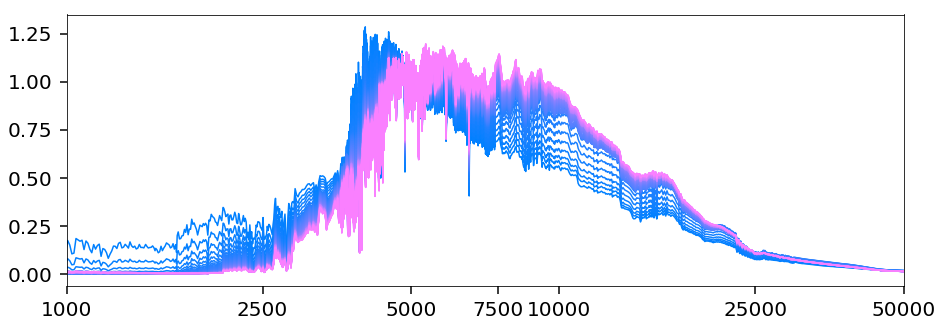

In [120]:
sp.params['logzsol'] = np.log10(1)
sp.params['dust2'] = 0


plt.figure(figsize=[15,5])
for i in range(len(AGE)):
    wave,flux = sp.get_spectrum(tage=AGE[i],peraa=True)
    plt.plot(np.log10(wave),flux / flux[2000], color = [i / len(AGE),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))

In [121]:
DUST = np.arange(0,1.5,.1)

(3.0, 4.698970004336019)

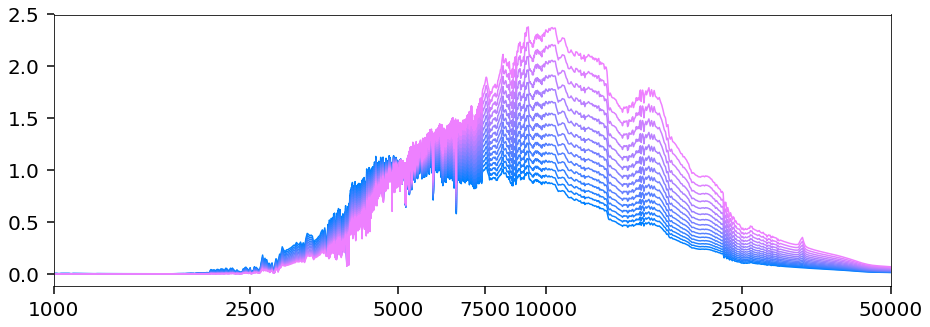

In [122]:
sp.params['logzsol'] = np.log10(0.019/0.019)
sp.params['mwr'] = 3.1
sp.params['uvb'] = 1


plt.figure(figsize=[15,5])
for i in range(len(DUST)):
    sp.params['dust2'] = DUST[i] 
    
    wave,flux = sp.get_spectrum(tage=3.0,peraa=True)
    plt.plot(np.log10(wave),flux /flux[2000], color = [i / len(DUST),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))

/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:264: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:266: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:273: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:275: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


(3.0, 4.698970004336019)

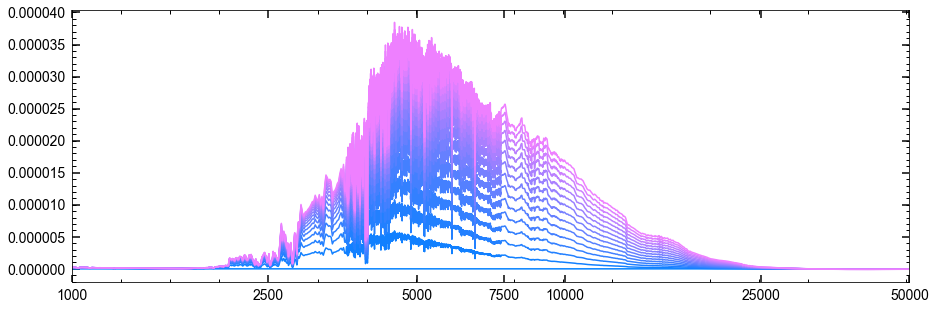

In [120]:
sp.params['logzsol'] = np.log10(0.019/0.019)
sp.params['mwr'] = 3.1
sp.params['uvb'] = 1
sp.params['dust2'] = 0

plt.figure(figsize=[15,5])
for i in range(len(DUST)): 
    sp.params['dust2'] = DUST[i] 
    
    wave1,flux1 = sp.get_spectrum(tage=3.0,peraa=True)
    
    sp.params['dust2'] = 0

    wave2,flu2 = sp.get_spectrum(tage=3.0,peraa=True)
    plt.plot(np.log10(wave),flux - flux * Salmon(DUST[i],wave) , color = [i / len(DUST),.5,1])

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))

(3.0, 4.698970004336019)

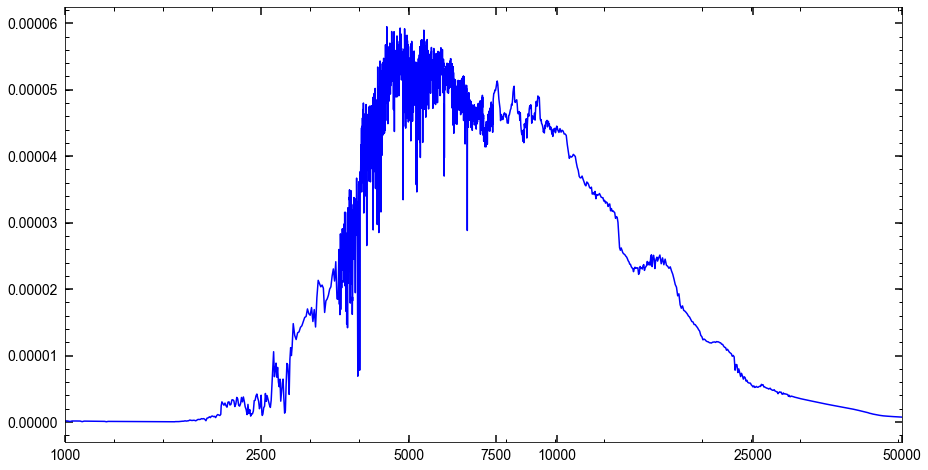

In [61]:
plt.figure(figsize=[15,8])
sp.params['logzsol'] =np.log10(1)
wave,flux = sp.get_spectrum(tage=2.5,peraa=True)
plt.plot(np.log10(wave),flux,color=[0,0,1])
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000,50000]),[1000,2500,5000,7500,10000,25000,50000])
plt.xlim(np.log10(1000),np.log10(50000))
# plt.ylim(-0.000001,0.00001)

In [50]:
len(dres.logl), np.where(dres.logl == np.max(dres.logl)), dres.logl[24453]

(24454, (array([24453]),), -92.57094180396024)

In [51]:
dres.samples[24453]

array([3.28629085e-01, 3.21741605e+00, 1.09566430e-02, 1.25318107e+00,
       2.07411413e-01, 3.49182299e-05])

In [81]:
dres.logl[IDX[242]]

-121.98316790692272

In [111]:
in1 = np.loadtxt('/Users/vestrada/alf/atlas_ssp_t03_Zp0.0.abund.krpa.s100').T

In [127]:
sp.params['logzsol'] = np.log10( 1 )
# sp.params['tau'] = 0.1
sp.params['sfh'] = 0

sp.params['dust2'] = 0.0

wave, flux = sp.get_spectrum(tage = 3, peraa = True)

(3.5, 4.5)

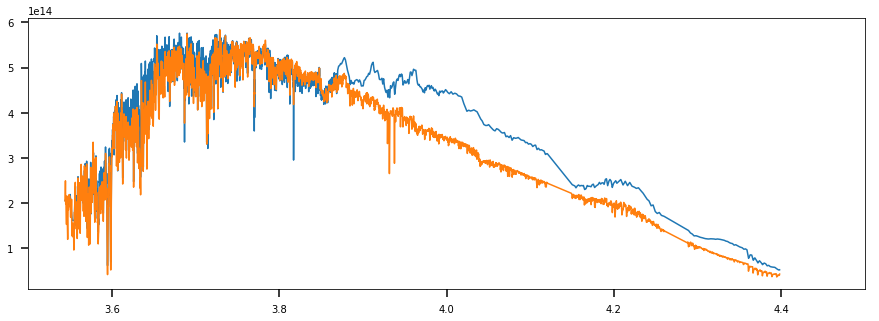

In [132]:
iflux = interp1d(wave,flux)(in1[0])
plt.figure(figsize=[15,5])
# plt.plot(np.log10(wave),flux*1.5E19)
plt.plot(np.log10(in1[0]), iflux*.9E19)
plt.plot(np.log10(in1[0]), (3E18 / in1[0]**2)*in1[1])



plt.xlim(3.5,4.5)

In [ ]:
0.001